# MD analysis

In [1]:
#

## Installation et importation

Le package MDAnalysis peut être installé avec les commandes suivantes :
-   ```bash
    conda install -c conda-forge mdanalysis
    ```
-   ```bash
    pip install MDAnalysis
    ```

Package optionnel pour la visualisation 3D des protéines, `nglview`:
-   ```bash
    conda install -c conda-forge nglview
    ```
-   ```bash
    pip install nglview
    ```

In [2]:
import MDAnalysis as mda
import pandas as pd 
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Ce tutoriel est réalisé sur la version 2.7.0, qui est la version mise à jour en Décembre 2023.

## Notions de base de MDAnalysis

MDAnalysis définie deux principales clases d'objets:
-   `Universe`
-   `AtomGroup`

### Universe

* Tout travail avec MDanalysis doit commencer par la définition de l' `Universe`, qui contient toutes les informations décrivant un système de dynamique moléculaire. Elle est initialisée à partir d'un fichier de **topologie**, qui définit les atomes dans le système, et d'un fichier de **trajectoire** , qui liste la position de chaque atome pour un certain nombre de frames.

* Dans MDAnalysis, nous parlons d'une hiérarchie de conteneurs : `Segment` > `Résidu` > `Atome`, et nous avons également des conteneurs qui peuvent englober différents niveaux comme `AtomGroup` qui est "juste un groupe d'atomes"

* L'avantage de MDAnalysis est que toute la trajectoire n'est pas chargée, ce qui permet d'économiser de l'espace mémoire.

* ?? memory false par défaut    , fichiers tempos

* L'univers permet de faire le lien entre :
    -   les fichiers de topologie ==> Informations statiques sur les atomes
        -   Nom, masse, type
        -   Liaisons covalentes (table de connectivité)
        -   Angles et dièdres
        -    ...
        - **format** : PDB, PDBQT , PSF( from charmm or namd) , gro ( gromacs)
    -   Trajectoire ==> Informations dynamiques
        -   Coordonnées des atomes pour chaque frame ($\delta$ t)
        -   Vitesse, force, dimensions de la boîte
        -   **format**: DCD ( charmm , namd) , trr , xtc ( gromacs) , gro & pdb

**Remarque** :
-   Dans le fichier trajectoire, des coordonnées correspondant à chaque atome doivient suivre le même ordre que les atomes donnés dans le fichier Topologie.
-   MDAnalysis stocke les trajectoires en utilisant ses unités internes : **Å (ångström)** pour la longueur et **ps (picoseconde)** pour le temps, indépendamment du format de données MD d'origine.

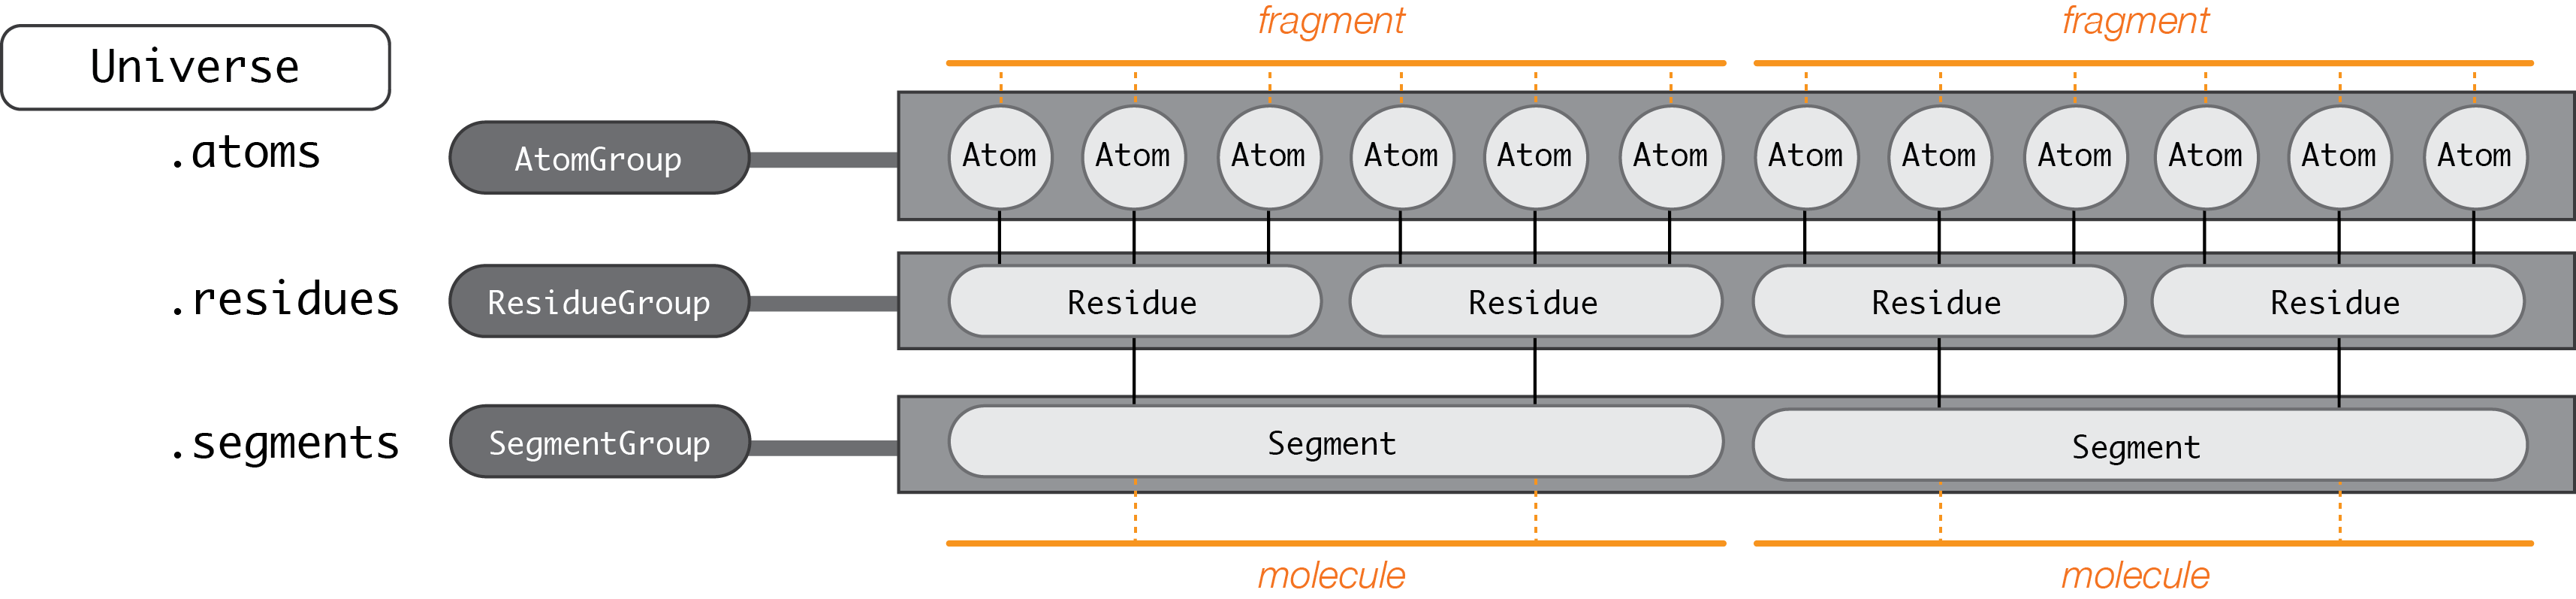

In [3]:
from IPython.display import Image
Image("./img/photo1.png")

***Liste des méthodes dans chaque conteneur***

In [4]:
Image(url= "https://onlinelibrary.wiley.com/cms/asset/cfc04ceb-6c33-4867-bfcd-087364458f0e/mfig002.jpg")


**Charger l'univers :**
  
```python
u = mda.Universe("topology_file", "trajectory_file")

# Utiliser un seul fichier
# Dans ce cas, le fichier PDB est considéré comme à la fois la topologie et la trajectoire.
u = mda.Universe("PDB_file")

# Utiliser une liste de trajectoires :
u = mda.Universe("topology_file", [traj1, traj2, ... trajn])
```

In [5]:
topology_file = "./PDB_tubuline.pdb"
trajectory_file = "./trajectoire_tubuline.dcd"

u = mda.Universe(topology_file, trajectory_file)

/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [6]:
# Vérifier le pas de temps en ps
u.trajectory.dt

0.04888821

Objet de l'univers :

In [7]:
# Tous les atomes du système
u.atoms

<AtomGroup with 6924 atoms>

*Cet objet appartient à la classe `AtomGroup`* 

In [8]:
# Tous les résidus du système.
u.residues

<ResidueGroup with 450 residues>

In [9]:
# Tous les segments du système.
u.segments



<SegmentGroup with 1 segment>

Toutes les liaisons, angles, dièdres et laisons impropres dans le système en tant que `TopologyObjects` si le informations sont disponibles

```python
u.bonds
u.angles
u.dihedrals
u.impropers
```

Possibilité de créer un univers à partir de différentes classes `AtomGroup` 

```python
from MDAnalysis.core.universe import Merge()

u1 = mda.Universe("PDB_file1")
u2 = mda.Universe("PDB_file2")
u = Merge(u1.atoms, u2.atoms)
```

### AtomGroup

Un `Universe` contient toutes les particules du système.
Une particule est appelée **atom**, quelque soit sa taille.

Une sélection d'**Atoms** est regroupée dans `AtomGroup`. Cette classe est l'objet le plus important dans MDAnalysis, car tout est accessible à travers elle.

#### Sélection d'AtomGroup

##### Sélection par mots-clés :

UN `AtomGroup` peut être sélectionné avec des mots-clés avec la fonction  `.selecte_atoms("keyword selection")`  

Voici quelques mots-clés de sélection importants :
-   `protein` ==> Sélectionne tous les atomes de la protéine.
-   `backbone` ==> Sélectionne uniquement les atomes du backbone atoms de la protéine.
    -   Noms des atomes : CA, C, O, N
-   `resname RESIDUE_NAME` ==> Tous les atomes de tous les résidus donnés ex: `resname GLY`
-   `resnum` ==> Tous les atomes d'un seul résidu ou d'une range de résidus.
    -   Résidu unique: `resnum 1`
    -   Range,  2 numéros séparés par `:` **inclusive**: `resnum 1:5`
-   `name ATOM_NAME` ==>  Tous les atomes avec le même nom, ex: `name CA`

Toutes les sélections de chaînes comme `resname` et `name` peuvent être associées à des shell-style wildcards d'Unix:
-   `*`sélectionne n'importe quel caractère.
-   `[seq]`  sélectionne n'importe quel caractère dans `seq`
-   `[!seq]` sélectionne n'importe quel caractère qui n'est pas dans `seq`  
Par exemple, `GL*` donne  GLY, GLU, GLN, GLX29.... `GL[YN]` donne uniquement GLY & GLN.

Il est possible de faire des sélections avancées avec les opérateurs booléens `not`, `and`, `or`.
Les parenthèses peuvent être utilisées pour changer l'ordre de lecture par défault (de gauche à droite).

In [10]:
ag1 = u.select_atoms("resname ARG")
ag2 = u.select_atoms("resname ARG and not (name H or name O)")
ag3 = u.select_atoms("resname ARG and not (name H* or name O)")
ag4 = u.select_atoms("(name H* or name O) and not resname ARG")

print(f"Nombre d'atomes dans le groupe 1: {len(ag1)}")
print(f"Nombre d'atomes dans le groupe 2: {len(ag2)}")
print(f"Nombre d'atomes dans le groupe 3: {len(ag3)}")
print(f"Nombre d'atomes dans le groupe 4: {len(ag4)}")


Nombre d'atomes dans le groupe 1: 528
Nombre d'atomes dans le groupe 2: 506
Nombre d'atomes dans le groupe 3: 220
Nombre d'atomes dans le groupe 4: 3528


D'autres types de sélection, comme les acides nucléiques, la sélection géométrique, dynamique, etc., sont possibles.  
Voir [Atom selection web page](https://userguide.mdanalysis.org/stable/selections.html#selections) pour plus d'informations.

##### Sélection par index

Les `AtomGroup` sont indexables et itérables :
Un atome particulier peut être renvoyé en utilisant son index indiqué entre crochets.

In [11]:
atom0 = u.atoms[0]  # Premier atome dans l'univers
atom0

<Atom 1: N of type N of resname MET, resid 1 and segid PROA and altLoc >

La sélectrion peut aussi être effectuée avec des tranches (et des pas) ou en indexant une liste 

In [12]:
ag1 = u.atoms[0:6:2]
print(f"Nombre d'atomes dans le groupe 1 : {len(ag1)} correspondant aux indices suivants: {ag1.indices}")

Nombre d'atomes dans le groupe 1 : 3 correspondant aux indices suivants: [0 2 4]


In [13]:
idx_list = [0, 2, 3, -1 ]
ag2 = u.atoms[idx_list]
print(f"Nombre d'atomes dans le groupe 1: {len(ag2)} correspondant aux indices suivants: {ag2.indices}")

Nombre d'atomes dans le groupe 1: 4 correspondant aux indices suivants: [   0    2    3 6923]


*Remarque:*
-   *La méthode `.indices` renvoie les indices des atomes sélectionnés dans l'objet `AtomGroup` sous la forme d'un tableau numpy (ndarray)*
-   *Il est possible de sélectionner deux fois ou plus le même atome.*

In [14]:
type(ag2.indices)

numpy.ndarray

Création d'un groupe via une liste d'atomes avec fonction `AtomGroup()`

In [15]:
atom1 = u.atoms[10]
atom2 = u.atoms[100]
atom3 = u.atoms[1000]
list_atoms = [atom1, atom2, atom3]
ag3 = mda.AtomGroup(list_atoms)

Il est posible de parcourir un `AtomGroup` en l'iterant à l'aide d'une boucle `for`:

In [16]:
for atom in ag3:
    print(atom)
    

<Atom 11: HG1 of type H of resname MET, resid 1 and segid PROA and altLoc >
<Atom 101: ND1 of type N of resname HSD, resid 6 and segid PROA and altLoc >
<Atom 1001: HD22 of type H of resname LEU, resid 65 and segid PROA and altLoc >


#### Quelques méthodes appliquées aux AtomGroup

In [17]:
# Sélection de la protéine
protein = u.select_atoms("protein")


#update des atoms

##### Positions des atoms : x, y, z

In [18]:
positions = protein.positions
positions

array([[-27.168, -17.412,   8.633],
       [-27.536, -17.222,   9.587],
       [-26.391, -18.1  ,   8.727],
       ...,
       [-20.57 ,  43.291,   6.41 ],
       [-19.894,  42.232,   6.313],
       [-20.642,  43.987,   7.458]], dtype=float32)

##### Nom et types des atoms :

In [19]:
# Noms spécifiques des atoms de la sélection dans la structure
print(protein.names)
# Types des atoms de la sélection dans la structure
print(protein.types)

['N' 'HT1' 'HT2' ... 'C' 'OT1' 'OT2']
['N' 'H' 'H' ... 'C' 'O' 'O']


##### Centre de masse et de géométrie : 

Le **centre de masse** est le point pondéré par les masses atomiques . 

$$
\text{Centre de masse} = \frac{\sum_i (m_i \cdot r_i)}{\sum_i m_i}
$$

- $m_i$ est la masse de l'atome $i$
- $r_i$ est la position de l'atome $i$


In [20]:
protein.center_of_mass()

array([-39.60372378,   0.25864408,  -1.8810289 ])

Le **centre de géométrie** ou centre des positions, est la moyenne des coordonnées des atomes, sans tenir compte de leurs masses. 
$$
\text{Centre de géométrie} = \frac{\sum_i r_i}{N}
$$

- $r_i$ est la position de l'atome $i$
- $N$ est le nombre total d'atomes


In [21]:
protein.center_of_geometry()

array([-39.706961  ,   0.06718155,  -2.03498223])

#### Group operator et set methods

Les Group operator et les set operator ont des objectifs similaires : ils comparent et construisent de nouveaux groupes à partir de différents `AtomGroup`. En revanches ils diffèrent dans leurs fonctionnement:
-   Group operator:
    -   `+`, `.concatenate()`, `.substract()`
    -   Gardent tous les atomes des deux groupes, en **préservant l'ordre** de chaque groupe.
    -   Un atome peut être repséenté deux fois

In [22]:
# Nouveau groupe avec tous les éléments de ag1 & de ag2
plus = ag1 + ag2
concat = ag1.concatenate(ag2)
print(f"ag1: {ag1.indices}")
print(f"ag2: {ag2.indices}")
print(f"plus: {plus.indices}")
print(f"concat: {concat.indices}")


ag1: [0 2 4]
ag2: [   0    2    3 6923]
plus: [   0    2    4    0    2    3 6923]
concat: [   0    2    4    0    2    3 6923]


In [23]:
# Nouveau groupe avec tous les éléments de ag2 qui ne sont pas dans ag1
subs = ag2.subtract(ag1)
print(f"substrate: {subs.indices}")

substrate: [   3 6923]


-   Set methods
    -   `|`, `.union()`, `.difference()`
    -   Renvoient un`AtomGrou` **UNIQUE** et **ORDONNÉ SUR LA TOPOLOGIE** 

In [24]:
#  Union : éléments provenant à la fois de ag1 et de ag2
uni_symbol = ag1 | ag2
uni_function = ag1.union(ag2)
print(f"ag1: {ag1.indices}")
print(f"ag2: {ag2.indices}")
print(f"uni_symbol: {uni_symbol.indices}")
print(f"uni_function: {uni_function.indices}")


ag1: [0 2 4]
ag2: [   0    2    3 6923]
uni_symbol: [   0    2    3    4 6923]
uni_function: [   0    2    3    4 6923]


In [25]:
# Différence : Dans ag1 mais pas dans ag2
minus_1_2 = ag1 - ag2
dif_1_2 = ag1.difference(ag2)
print(f"minus 1-2: {minus_1_2.indices}")
print(f"dif 1-2: {dif_1_2.indices}")

# Dans ag2 mais pas dans ag1
minus_2_1 = ag2 - ag1
dif_2_1 = ag2.difference(ag1)
print(f"minus 2-1 : {minus_2_1.indices}")
print(f"dif 2-1: {dif_2_1.indices}")


minus 1-2: [4]
dif 1-2: [4]
minus 2-1 : [   3 6923]
dif 2-1: [   3 6923]


*Remarque : L'ordre est important !*

In [26]:
# Intersection : Éléments communs à ag1 et ag2
and_symb = ag1 & ag2
inter = ag1.intersection(ag2)
print(f"and_symb : {and_symb.indices}")
print(f"inter : {inter.indices}")

and_symb : [0 2]
inter : [0 2]


In [27]:
#ag1 = u.select_atoms("resname ARG")

### Trajectoire

MDAnalysis ne charge pas tous les frames de la trajectoire afin d'économiser de la mémoire.  
L'univers est dans un état défnie avec un temps fixe associé à la trajectoire.  
Lorsque ce temps change ==> Les données associées se décalent également.

Chaque temps est indexé dans une liste accessible via `.trajectory`

In [28]:
print(type(u.trajectory))
print(len(u.trajectory))
print(f" Premier pas de temps : {u.trajectory[0]};\n Dernier pas de temps: {u.trajectory[-1]}")

<class 'MDAnalysis.coordinates.DCD.DCDReader'>
1000
 Premier pas de temps : < Timestep 0 >;
 Dernier pas de temps: < Timestep 999 with unit cell dimensions [209.88437 136.6689  136.6689   90.       90.       90.     ] >


Concretement, l'univers ne garde en mémoire que le dernier temps appelé.

In [29]:
u.trajectory[0]
print(f"Temps de la 1ère frame :{u.trajectory.time} ps")
u.trajectory[9]
print(f"Temps de la 10 ème  frame: {u.trajectory.time} ps")
u.trajectory[99]
print(f"Temps de la 100ème frame: {u.trajectory.time} ps")
u.trajectory[-1]
print(f"Temps de la dernière  frame: {u.trajectory.time} ps")

Temps de la 1ère frame :0.0 ps
Temps de la 10 ème  frame: 0.43999389 ps
Temps de la 100ème frame: 4.83993279 ps
Temps de la dernière  frame: 48.83932179 ps


La trajectoire peut également être découpée afin de ne travailler que sur une partie de la simulation.

In [30]:
for ts in u.trajectory[:500:100]:
    print(f"frame: {ts.frame:>3}, temps: {ts.time:>5.0f} ps")

frame:   0, temps:     0 ps
frame: 100, temps:     5 ps
frame: 200, temps:    10 ps
frame: 300, temps:    15 ps
frame: 400, temps:    20 ps


# Ecriture d'une trajectoire

In [31]:
# Extraire les carbone alpha de tous ou certains frames 
u = mda.Universe('./PDB_tubuline.pdb', "./trajectoire_tubuline.dcd")

CA = u.select_atoms("name CA")
# Toutes les frames
CA.write('CA_all.pdb', frames='all')
# Du début au frame 200
CA.write('CA_0_to_200_frames.pdb', frames=u.trajectory[0:201])


/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


## Analyse

L'objectif principal de ce package est d'analyser les trajectoires de simulations de dynamique moléculaire.  
Le module `MDanalysis.analysis` contient toutes les dépendances pour l'analyse, par exemple, le RMSD, l'alignement, etc.

### Alignement

Puisque la protéine se déplace à l'intérieur de la boîte, il est nécessaire d'aligner la structure pendant la trajectoire avec une structure de référence (par exemple, la 1er frame).
Cette action peut être effectuée avec la fonction `.AlignTraj` de la dépendance `align`

In [32]:
from MDAnalysis.analysis import align

/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


Puisque MDAnalysis ne conserve pas les informations lorsque le cadre est changé, la méthode `.AlignTraj` epermet d'enregistrer la nouvelle trajectoire dans un autre fichier.  
Si la trajectoire n'est pas enregistrée, la méthode n'aura aucun effet sur l'originale.

In [33]:
ref = u.copy()  # Faire une copie pour conserver la trajectoire originale
                # Si aucune copie n'est faite ==> La trajectoire de référence peut être modifiée pendant l'alignement

In [34]:
ref.trajectory[0]  # Sélectionner la frame de réference
align.AlignTraj(u,  # Trajectoire à aligner
                ref,   # frame de référence
                select = "name CA",  # Alignement sur les atomes CA
                filename = "aligned.dcd",  # Fichier pour stocker la nouvelle trajectoire
                match_atoms = True,  # s'il faut faire correspondre les atomes en fonction de la masse
                ).run()


/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:463: UserWarning: No dimensions set for current frame, zeroed unitcell will be written
  warnings.warn(wmsg)


==> La trajectoire alignée est enregistrée dans un nouveau fichier bien que la trajectoire originale a conservé ses caractéristiques.

In [35]:
# Charger la trajectoire alignée dans le nouvel univers
aligned_u = mda.Universe("PDB_tubuline.pdb", "aligned.dcd")

Il est possible de ne pas écrire dans un fichier en chargeant toute la trajectoire en mémoire en utilisant l'argument `in_memory=Ture`. Cela n'est pas toujours faisable dans le cas de fichiers volumineux.

In [36]:
aligner = align.AlignTraj(u, ref,
                          select='name CA',
                          in_memory=True).run()

Cet objet permet d'aligner toute la trajectoire de l'univers chargé. Désormais, toutes les frames de l'univers sont alignées, et le calcul du RMSD (Root Mean Square Deviation) et du RMSF (Root Mean Square Fluctuation) peuvent être effectué directement.  
Il est à noter que le code crée un objet qui a pour unique fonction d'aligner l'univers. La méthode de chaînage est utilisée pour exécuter l'alignement, ce qui équivaut à  `aligner.run()`

### RMSD

$\text{RMSD} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( \left( x_i^{\text{ref}} - x_i^{\text{traj}} \right)^2 + \left( y_i^{\text{ref}} - y_i^{\text{traj}} \right)^2 + \left( z_i^{\text{ref}} - z_i^{\text{traj}} \right)^2 \right)}$


In [37]:
# Importation
from MDAnalysis.analysis import rms

Pour le calcul du RMSD, la superposition des structures est indispensable, car la protéine peut se déplacer à l'intérieur de la boîte. La fonction `RMSD()` du module `rms` peut effectuer cet alignement avec une référence donnée. Il n'est donc pas utile d'effectuer l'alignement précédent.

In [38]:
# Analyse du RMSD
rmsd_analysis = rms.RMSD(
    u,  # Univers à aligner
    u,  # Univers de référence
    select = "backbone",  # Groupe à superposer et pour calculer le RMSD
    ref_frame = 0)  # index de la frame de référence
rmsd_analysis.run()

Si l'alignement a déjà été effectué, le RMSD peut être calculé directement sur l'univers :

In [39]:
rmsd_analysis = rms.RMSD(u, select="backbone").run()

Les résultats sont enregistrés dans  `rmsd_analysis.rmsd`  sous la forme d'un tableau ([frame, time (ns), selections])

In [40]:
rmsd_analysis.results.rmsd[1]

array([1.        , 0.04888821, 1.27971401])

In [41]:
# Stocker le RMSD dans un dataframe
rmsd_df = pd.DataFrame(rmsd_analysis.results.rmsd, columns= ["Frame", "Temps", "RMSD_du_backbone"])
rmsd_df.tail()

,Frame,Temps,RMSD_du_backbone
995,995.0,48.643769,8.163880
996,996.0,48.692657,7.953098
997,997.0,48.741545,7.662205
998,998.0,48.790434,7.648626
999,999.0,48.839322,7.902481


<>:4: SyntaxWarning: invalid escape sequence '\A'
<>:4: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_4371/2145722066.py:4: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSD ($\AA$)')


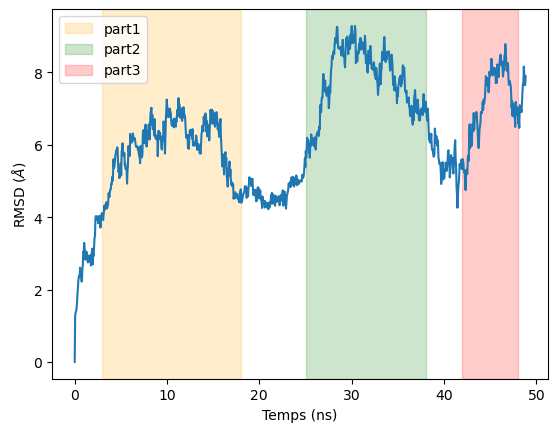

In [42]:
# Tracer le RMSD
plt.plot(rmsd_df["Temps"], rmsd_df["RMSD_du_backbone"])
plt.xlabel('Temps (ns)')
plt.ylabel('RMSD ($\AA$)')
plt.axvspan(3, 18, zorder=0, alpha=0.2, color='orange', label='part1')
plt.axvspan(25, 38, zorder=0, alpha=0.2, color='green', label='part2')
plt.axvspan(42, 48, zorder=0, alpha=0.2, color='red', label='part3')
plt.legend()
plt.show()

### RMSF

$\text{RMSF}_i = \sqrt{\frac{1}{N} \sum_{t=1}^{N} \left( \left( x_i(t) - \langle x_i \rangle \right)^2 + \left( y_i(t) - \langle y_i \rangle \right)^2 + \left( z_i(t) - \langle z_i \rangle \right)^2 \right)}$


Analyse du RMSF qui a été préalablement aligné.
La fluctuation est mesurée par la comparaison des atomes $C\alpha$

In [43]:
c_alphas = u.select_atoms('protein and name CA')
rmsf_analysis = rms.RMSF(c_alphas).run()

<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_4371/1623261741.py:3: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')


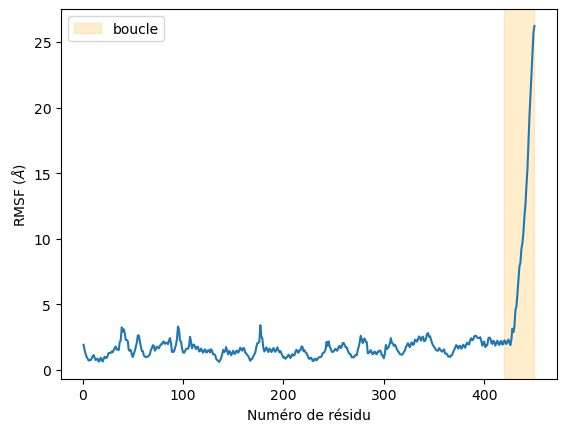

In [44]:
plt.plot(c_alphas.resids, rmsf_analysis.results.rmsf)
plt.xlabel('Numéro de résidu')
plt.ylabel('RMSF ($\AA$)')
plt.axvspan(420, len(c_alphas.resids), zorder=0, alpha=0.2, color='orange', label='boucle')
plt.legend()

### Rayon de giration

Le rayon de giration mesure à quel point la protéine est compacte ; il peut être calculé ainsi :

$\mathbf{r}_{\text{cm}} = \frac{\sum_{i=1}^{N} m_i \mathbf{r}_i}{\sum_{i=1}^{N} m_i}$

Il n'existe pas de méthode qui calcule le rayon de giration pour toute frames de la simulation. Il doit être calculé un par un.

In [45]:
time = []
rgyr = []  # Rayon de giration

protein = u.select_atoms("protein")

for _ in u.trajectory:  #  itérer sur toutes frames
    time.append(u.trajectory.time)
    
    # Utiliser une méthode AtomGroup
    rgyr.append(protein.radius_of_gyration())
    
# Création du dataframee:
rgyr_df = pd.DataFrame(rgyr, columns = ["Rayon_de_Giration"] ,index=time)
rgyr_df.index.name = "Temps"

<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:5: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_4371/2482261507.py:5: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel("Rayon de Giration($\AA$)")


Text(0, 0.5, 'Rayon de Giration($\\AA$)')

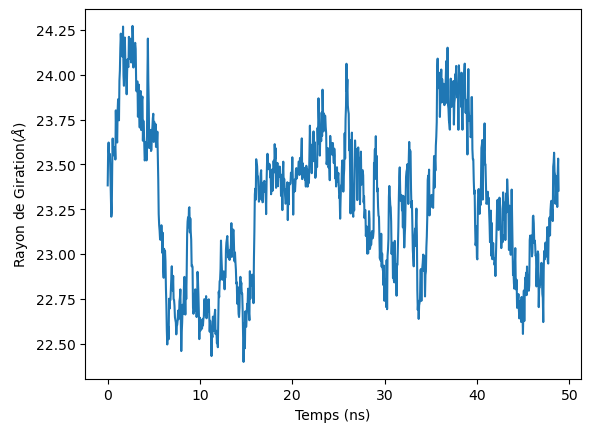

In [46]:
# Tracer le graphique avec Mathplotlib
fig, ax = plt.subplots()
ax.plot(rgyr_df)
ax.set_xlabel("Temps (ns)")
ax.set_ylabel("Rayon de Giration($\AA$)")

### Visualisation 

In [48]:
import nglview as nv

u = mda.Universe('./PDB_tubuline.pdb' , "./trajectoire_tubuline.dcd" )
view = nv.show_mdanalysis(u)
view

/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=999)

### Visualisation des parties flexibles

In [61]:
u = mda.Universe('./PDB_tubuline.pdb', './trajectoire_tubuline.dcd')

# Sélection des atomes CA pour l'analyse RMSF
c_alphas = u.select_atoms('protein and name CA')

# Récupérer les valeurs du RMSF
rmsf_values = rmsf_analysis.results.rmsf
# Appliquer les valeurs de RMSF aux b-factors des atomes CA directement en mémoire
c_alphas.tempfactors = rmsf_values

# Visualiser avec nglview en appliquant la couleur selon le champ b-factor (RMSF) 
view = nv.show_mdanalysis(u)
view.clear_representations() # important pour colorer 
view.add_cartoon(color="bfactor", selection="protein")
view


/home/etudiant/.conda/envs/reguei/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=999)